In [3]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns

WORK_SPACE = "/home/olle/PycharmProjects/LODE/workspace"

longitudinal_pd = pd.read_csv(os.path.join(WORK_SPACE, "sequence_data/longitudinal_data.csv"))
segmentation_statistics_pd = pd.read_csv(os.path.join(WORK_SPACE, "sequence_data/segmentation_statistics_vol.csv"))

#### pre process columns

In [2]:
id_cols = segmentation_statistics_pd.record.str.split("_", expand=True)[[0, 1 , 2, 3]]

segmentation_statistics_pd["patient_id"] = id_cols[0]
segmentation_statistics_pd["study_date"] = id_cols[1]
segmentation_statistics_pd["laterality"] = id_cols[2]

longitudinal_pd["study_date"] = longitudinal_pd.study_date.str.replace("-", "")

In [3]:
# cast data types
keys = ["patient_id", "study_date", "laterality"] 
for key in keys:
    longitudinal_pd[key] = longitudinal_pd[key].astype(str)
    segmentation_statistics_pd[key] = segmentation_statistics_pd[key].astype(str)

#### merge

In [4]:
longitudinal_abt = pd.merge(longitudinal_pd, segmentation_statistics_pd, how="inner", 
                            left_on = keys, right_on = keys)

feature_columns = list(longitudinal_abt.columns[17:])

#### correlation table

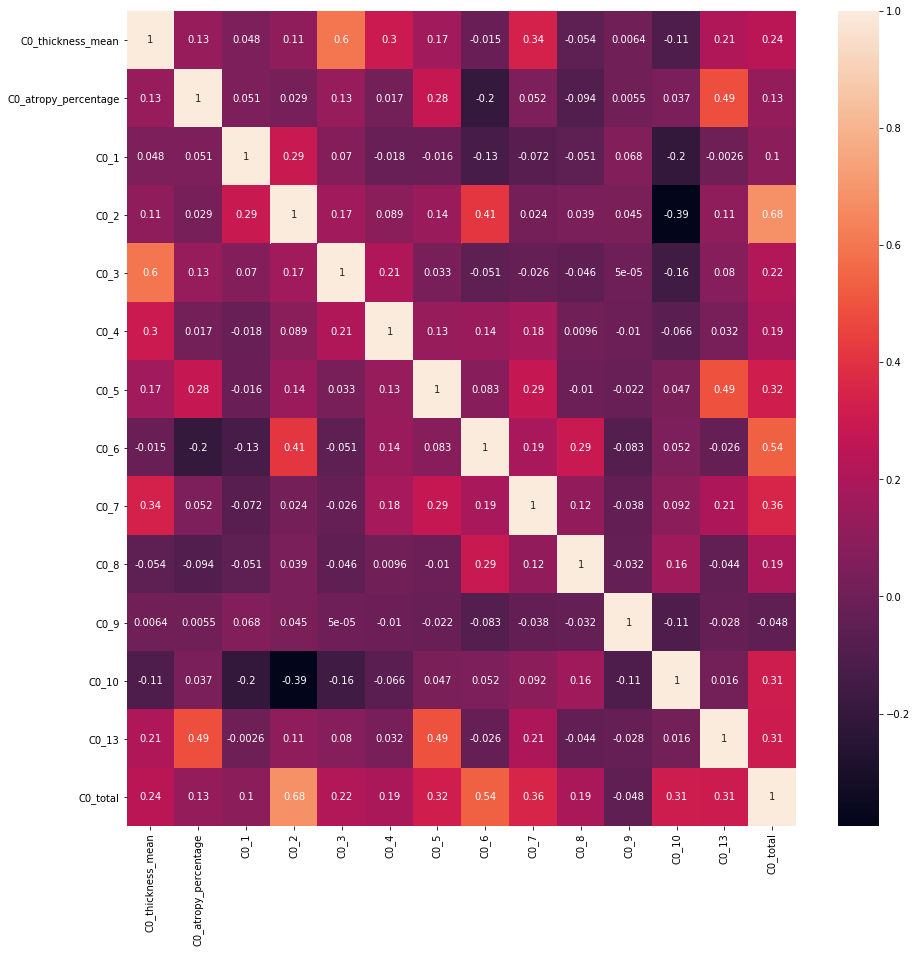

In [6]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))

fovea_feature_columns = [feature for feature in feature_columns if "C0" in feature]
corrMatrix = longitudinal_abt[fovea_feature_columns].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

### plot absolute effect for 3, 6, 12 months

In [4]:
time_2_dry_pd = pd.read_csv(os.path.join(WORK_SPACE, "sequence_data/time_until_dry.csv"))

In [13]:
time_2_dry_pd[time_2_dry_pd.patient_id == 1570]

,Unnamed: 0,patient_id,laterality,abs1_3,abs1_6,abs1_12,rel1_3,rel1_6,rel1_12,inj1_3,inj1_6,inj1_12
2,2,1570,R,0.02,0.08,0.08,0.5,2.5,4.5,3,3.0,5.0


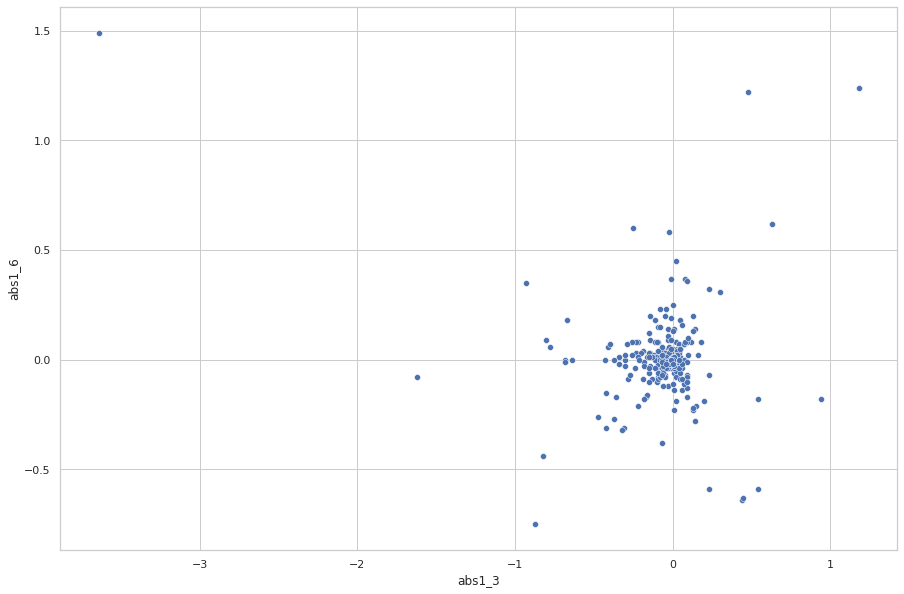

In [11]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(style="whitegrid")
sns.scatterplot(data=time_2_dry_pd, x="abs1_3", y="abs1_6")

In [72]:
effect_month = time_2_dry_pd[["abs1_3", "abs1_6", "abs1_12"]]

# rename columns for plotting
effect_month = effect_month.rename(columns={"abs1_3": "3", "abs1_6": "6", "abs1_12": "12"})

# make table long
effect_month_long = pd.melt(effect_month, value_vars=["3", "6", "12"], 
        var_name = "time", value_name = "effect")


effect_month_rel = time_2_dry_pd[["rel1_3", "rel1_6", "rel1_12"]]

# rename columns for plotting
effect_month_rel = effect_month_rel.rename(columns={"rel1_3": "3", "rel1_6": "6", "rel1_12": "12"})

# make table long
effect_month_rel_long = pd.melt(effect_month_rel, value_vars=["3", "6", "12"], 
        var_name = "time", value_name = "effect")

In [ ]:
#### aggregated statistics over data frames

In [70]:
summary_stats = pd.DataFrame([effect_month.mean(axis=0), effect_month.std(axis=0)]).T
summary_stats = summary_stats.rename(columns={0:"mean", 1:"std"})
summary_stats

,mean,std
3,-0.052610,0.266080
6,0.005090,0.174456
12,-0.013206,0.206845


#### compare relative changes

In [88]:
effect_month_rel = effect_month_rel.replace([np.inf, -np.inf], np.nan)
summary_stats = pd.DataFrame([effect_month_rel.mean(0, skipna=True), effect_month_rel.std(axis=0)]).T
summary_stats = summary_stats.rename(columns={0:"mean", 1:"std"})
summary_stats

,mean,std
3,0.244949,3.273498
6,0.857804,6.515305
12,0.329966,3.548862


[Text(0, 0.5, 'treatment effect measured in cubic mm'),
 Text(0.5, 0, '3, 6, and 12 month interval since first injection')]

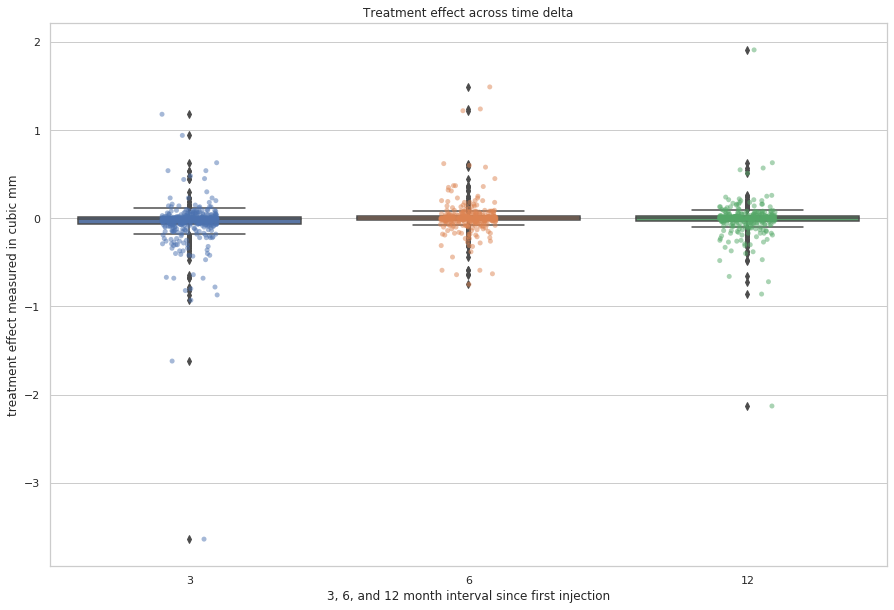

In [59]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="time", y="effect", data=effect_month_long)
ax = sns.stripplot(x="time", y="effect", data=effect_month_long, alpha=0.5)
plt.title("Treatment effect across time delta")
ax.set(xlabel="3, 6, and 12 month interval since first injection", 
       ylabel="treatment effect measured in cubic mm")

#### Effect cross injections plot

In [118]:
month3 = pd.melt(time_2_dry_pd[["abs1_3", "inj1_3"]], id_vars=["inj1_3"], value_vars=["abs1_3"])
month6 = pd.melt(time_2_dry_pd[["abs1_6", "inj1_6"]], id_vars=["inj1_6"], value_vars=["abs1_6"])
month12 = pd.melt(time_2_dry_pd[["abs1_12", "inj1_12"]], id_vars=["inj1_12"], value_vars=["abs1_12"])

month3 = month3.rename(columns={"inj1_3": "inj"})
month6 = month6.rename(columns={"inj1_6": "inj"})
month12 = month12.rename(columns={"inj1_12": "inj"})

effect_injections = month3.append(month6).append(month12)

[Text(0, 0.5, 'treatment effect from first measurement measured in cubic mm'),
 Text(0.5, 0, 'number of injections administrered')]

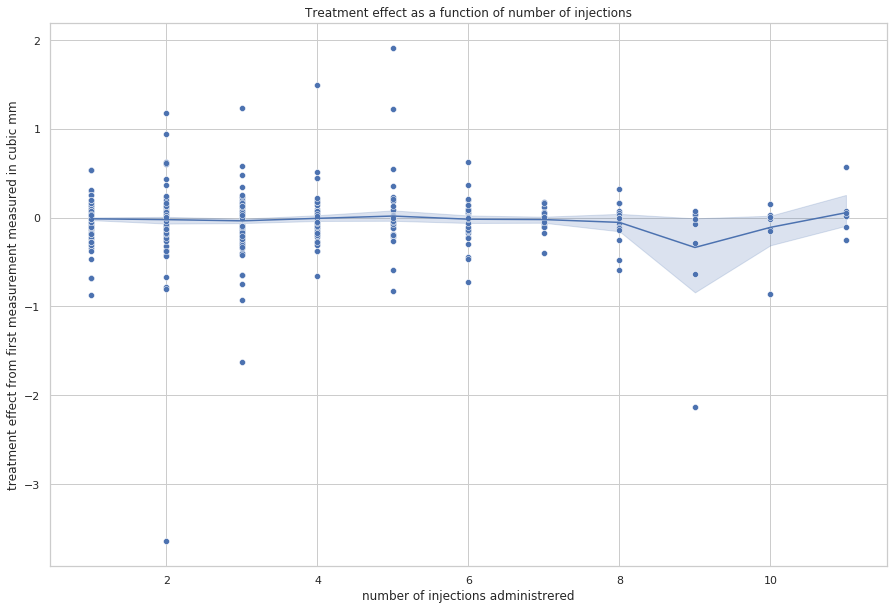

In [123]:
sns.lineplot(data=effect_injections, x="inj", y="value")
ax = sns.scatterplot(data=effect_injections, x="inj", y="value")
plt.title("Treatment effect as a function of number of injections")
ax.set(xlabel="number of injections administrered", 
       ylabel="treatment effect from first measurement measured in cubic mm")

In [124]:
#### examples

In [125]:
time_2_dry_pd

,Unnamed: 0,patient_id,laterality,abs1_3,abs1_6,abs1_12,rel1_3,rel1_6,rel1_12,inj1_3,inj1_6,inj1_12
0,0,1557,L,0.00,-0.02,0.04,0.000000,-1.000000,1.000000,3,3.0,3.0
1,1,1557,R,-0.09,-0.08,-0.17,-0.230769,-0.435897,-0.871795,3,3.0,3.0
2,2,1570,R,0.02,0.08,0.08,0.500000,2.500000,4.500000,3,3.0,5.0
3,3,3897,R,0.05,0.01,-0.06,5.000000,6.000000,0.000000,1,1.0,2.0
4,4,4206,L,-0.13,-0.09,0.12,-0.520000,-0.880000,-0.400000,1,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
405,405,311295,R,0.10,0.10,0.20,0.285714,0.571429,1.142857,1,1.0,1.0
406,406,312696,L,-0.82,-0.44,0.63,-0.379630,-0.583333,-0.291667,5,6.0,6.0
407,407,312696,R,0.48,1.22,1.91,0.238806,0.845771,1.796020,3,5.0,5.0
408,408,313872,L,0.00,-0.02,-0.05,0.000000,-0.285714,-1.000000,4,4.0,4.0
